#### Code demonstration
----
DANDI archive link: https://dandiarchive.org/ (search for datasets here)

All datasets are stored in NWB format, although some are naturally missing information.

The coolest tool that I'll show here is the nwbwidgets function

-------

Watson et al 2016 - recorded from PFC as rats slept

- https://dandiarchive.org/dandiset/000041?search=000041&pos=3

- doi: 10.1016/j.neuron.2016.03.036
----

#### Define dandiset
This is a dataset stored online with a unique identifier (below the title and to the left "ID")

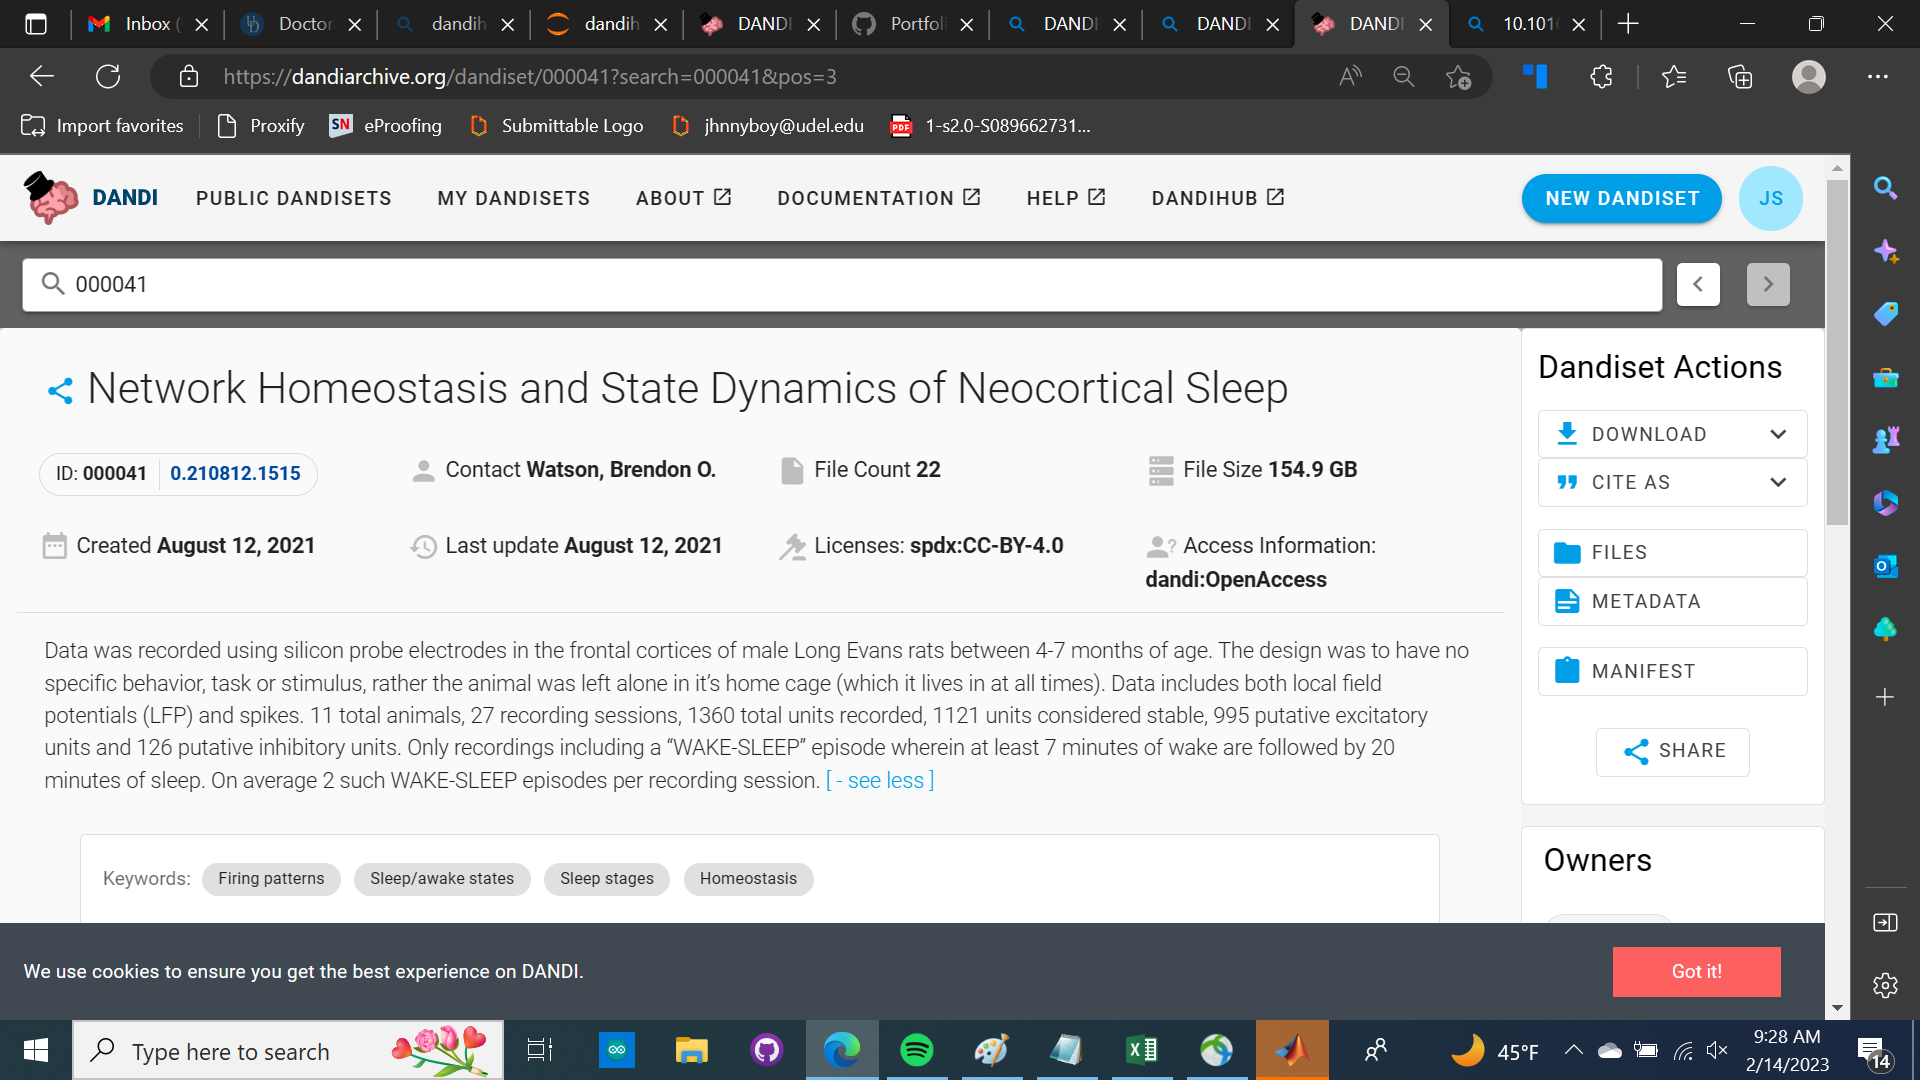

In [1]:
# dandiset ID
dandiset_id = '000041'

# libraries
import pynwb
import requests
from nwbwidgets import nwb2widget
from pynwb import NWBHDF5IO
import pandas
import numpy as np

#### Define functions to support streaming
Ben Dichtor wrote these

In [2]:
def _search_assets(url, filepath):
    response = requests.request("GET", url, headers={"Accept": "application/json"}).json() 
    
    for asset in response["results"]:
        if filepath == asset["path"]:
            return asset["asset_id"]
    
    if response.get("next", None):
        return _search_assets(response["next"], filepath)
    
    raise ValueError(f'path {filepath} not found in dandiset {dandiset_id}.')

def get_asset_id(dandiset_id, filepath):
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/"
    return _search_assets(url, filepath)

def get_s3_url(dandiset_id, filepath):
    """Get the s3 location for any NWB file on DANDI"""

    asset_id = get_asset_id(dandiset_id, filepath)
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/{asset_id}/download/"
    
    s3_url = requests.request(url=url, method='head').url
    if '?' in s3_url:
        return s3_url[:s3_url.index('?')]
    return s3_url

#### Stream with DANDI to get data
Here, we want to extract the dataset into something we can use

In [3]:
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
import os # import os

# lets get all sessions for each rat
with DandiAPIClient() as client:
    
    # get dandiset using the ID code
    dandiset = client.get_dandiset(dandiset_id,'draft')
    
    # list splits the "zipped" generator file
    assets   = list(dandiset.get_assets())
    
    # list comprehension
    rats = {os.path.split(x.path)[0] for x in assets} # list comprehension, for loop, {} if unique

    # actually just work with sessions for now and call it a day
    sessions = [x.path for x in assets]
    #print(sessions)

    #asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    #s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

-----
#### Before using the nwbwidgets, we need to select a rat and session

In [5]:
# Visualizing data
rats

{'sub-BWRat17',
 'sub-BWRat18',
 'sub-BWRat19',
 'sub-BWRat20',
 'sub-BWRat21',
 'sub-Bogey',
 'sub-Dino',
 'sub-Rizzo',
 'sub-Splinter',
 'sub-Templeton'}

In [4]:
# Sessions 
sessions

['sub-BWRat17/sub-BWRat17_ses-BWRat17-121912_ecephys.nwb',
 'sub-BWRat17/sub-BWRat17_ses-BWRat17-121712_ecephys.nwb',
 'sub-BWRat18/sub-BWRat18_ses-BWRat18-020513_ecephys.nwb',
 'sub-BWRat19/sub-BWRat19_ses-BWRat19-032413_ecephys.nwb',
 'sub-BWRat19/sub-BWRat19_ses-BWRat19-032513_ecephys.nwb',
 'sub-BWRat20/sub-BWRat20_ses-BWRat20-101013_ecephys.nwb',
 'sub-BWRat20/sub-BWRat20_ses-BWRat20-101513_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121613_ecephys.nwb',
 'sub-Bogey/sub-Bogey_ses-Bogey-012615_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121813_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121113_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-061814_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072314_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072114_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-061914_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072414_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-062014_ecephys.nwb',
 'sub-Rizzo/sub-Rizzo_ses-Rizzo-022715_ecephys.nwb',
 'su

-----
#### Diving into the data
Lets choose a session and extract data from the NWB dict

In [6]:
# select 1 session for now to get code working
tempAssetID = sessions[0]
asset_id = get_asset_id(dandiset_id, tempAssetID) # this is the URL for download
s3_path  = get_s3_url(dandiset_id, tempAssetID) # this is the path to streaming
#print(asset_id)

# use the "Read Only S3" (ros3) driver to stream data directly from DANDI (or any other S3 location)
io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')

# read nwb file according to the s3 bucket path
nwb = io.read()

#Get the fields within the NWB file
nwbFields = nwb.fields

# read out the nwb file as it is a dict
nwbFile = nwb.electrodes['location'].data[:]
#nwbFile = nwb.intervals['epochs']
regions = list(nwbFile)


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


------
Lets examine the structure and data types of our imported and extracted data "nwb"
- This includes metadata

In [7]:
nwb2widget(nwb)

In [8]:
# lets visualize the nwb dataset in python formatting
nwb

root pynwb.file.NWBFile at 0x139724008877904
Fields:
  devices: {
    implant <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    shank1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank3 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank4 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank5 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank6 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank7 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank8 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank9 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Brendon Watson']
  file_create_date: [datetime.datetime(2020, 10, 3, 13, 49, 41, 955624, tzinfo=tzoffset(None, -14400))]
  identifier: BWRat17_121912
  institution: NYU
  lab: Buzsaki
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ecephys <class 'pynwb.base.ProcessingModule'>
  }
  related_publ

------
Here is a widget used to explore the data in a user friendly manner

-----
#### Getting data into some manageable format

In [13]:
# get behavioral data into dataframe
df_behavior = nwb.processing['behavior']['states'].to_dataframe()
df_behavior.shape

(71, 3)

Note that what you see below is simplified.

You could also do the following (which closely resembles dict organization):

`nwb.processing['ecephys'].data_interfaces['LFP'].electrical_series['lfp']`

Extracting data - this may take a few minutes...

In [14]:
# get lfp data out from just 1 shank
lfpData_s1 = nwb.processing['ecephys']['LFP']['lfp'].data[:,0:8]

In [15]:
lfpData_s1.shape

(8168375, 8)

In [16]:
# get the sampling rate of LFP - make sure this is an int-type (rounded, whole number) for indexing
srate_lfp = nwb.processing['ecephys']['LFP']['lfp'].rate.astype(int)
type(srate_lfp)

numpy.int64

Make a temporary variable in order to visualize the signal

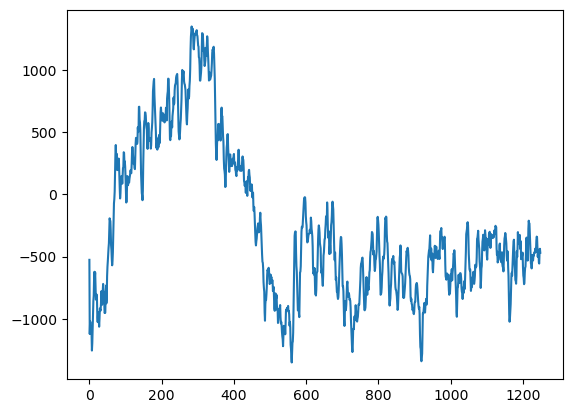

In [18]:
exData = lfpData_s1[0:1250-1,0]
# plot example trace
import matplotlib.pyplot as plt
plt.plot(exData)

Lets fit a regression line to the dataset - Is Prefrontal theta power changing over the course of the behavioral recording?

List Comprehension: first, we need to get new variables that represent event counts and theta power

In [59]:
# convert our numEvents variable via list comprehension
eventTemp = [[i] for i in numEvents]
powTemp = [[i] for i in powTheta]

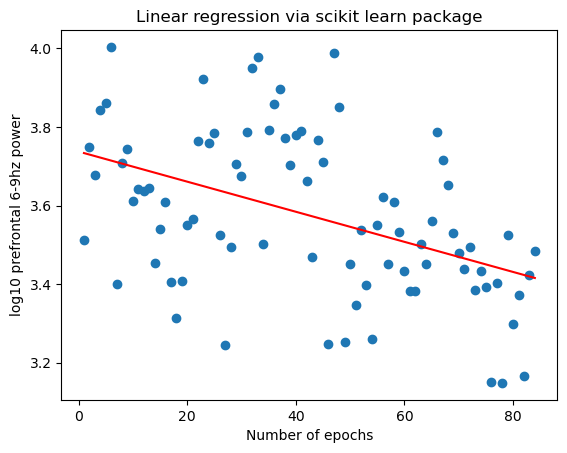

In [62]:
from sklearn.linear_model import LinearRegression

# Model initialization
reg = LinearRegression()

# Fit the data(train the model)
reg.fit(eventTemp, powTemp)

# Predict
y_pred = reg.predict(eventTemp)

# plot new fig
plt.scatter(eventTemp,powTemp)
plt.title('Linear regression via scikit learn package')
plt.xlabel('Number of epochs')
plt.ylabel('log10 prefrontal 6-9hz power')
plt.plot(numEvents, y_pred, color='r')
